In [2]:
import os
os.listdir()



['.config', 'BTC_USD_Yahoo.csv', 'sample_data']

In [ ]:
df.dtypes



,0
Close,object
High,object
Low,object
Open,object
Volume,object


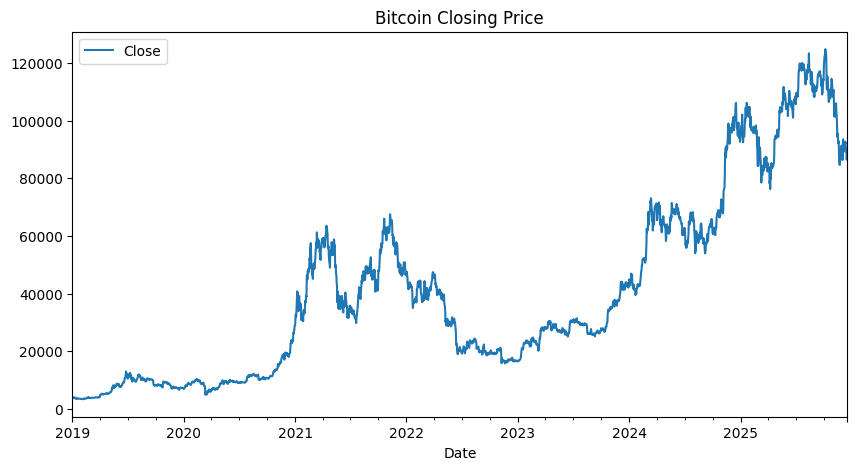

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Reload CSV cleanly
df = pd.read_csv('BTC_USD_Yahoo.csv')

# Convert Date
df['Date'] = pd.to_datetime(df['Date'])

# Remove commas and convert all numeric columns
num_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
for col in num_cols:
    df[col] = (
        df[col]
        .astype(str)
        .str.replace(',', '', regex=True)
    )
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Drop rows with missing values
df = df.dropna()

# Set Date as index
df = df.sort_values('Date')
df.set_index('Date', inplace=True)

# Plot Closing Price
df[['Close']].plot(figsize=(10,5), title='Bitcoin Closing Price')
plt.show()


In [9]:
from sklearn.metrics import mean_squared_error
import numpy as np

series = df['Close']

train_size = int(len(series) * 0.8)
train = series[:train_size]
test = series[train_size:]



In [10]:
from statsmodels.tsa.arima.model import ARIMA


In [11]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()

print(model_fit.summary())



/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 2034
Model:                 ARIMA(5, 1, 0)   Log Likelihood              -17163.685
Date:                Fri, 26 Dec 2025   AIC                          34339.369
Time:                        13:44:51   BIC                          34373.073
Sample:                    01-01-2019   HQIC                         34351.734
                         - 07-26-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0550      0.014     -3.807      0.000      -0.083      -0.027
ar.L2          0.0104      0.015      0.683      0.495      -0.019       0.040
ar.L3          0.0310      0.017      1.867      0.0

In [12]:
forecast = model_fit.forecast(steps=len(test))


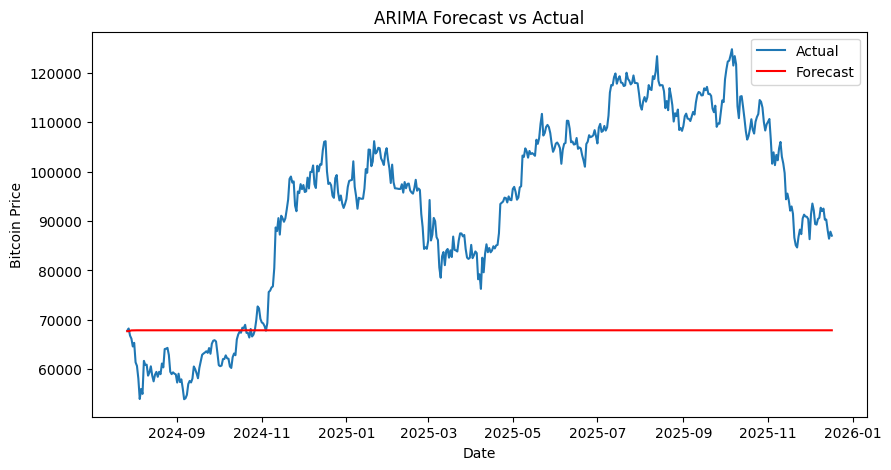

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.title('ARIMA Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Bitcoin Price')
plt.legend()
plt.show()


In [14]:
rmse = np.sqrt(mean_squared_error(test, forecast))
print("RMSE:", rmse)


RMSE: 31591.449124462528


In [17]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [18]:
sarima_model = SARIMAX(
    train,
    order=(5,1,0),
    seasonal_order=(1,1,1,12)
)

sarima_fit = sarima_model.fit()
print(sarima_fit.summary())


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                                Close   No. Observations:                 2034
Model:             SARIMAX(5, 1, 0)x(1, 1, [1], 12)   Log Likelihood              -17089.289
Date:                              Fri, 26 Dec 2025   AIC                          34194.579
Time:                                      14:46:48   BIC                          34239.470
Sample:                                  01-01-2019   HQIC                         34211.053
                                       - 07-26-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0516      0.014     -3.572      0.000      -0.080      -0.023
ar.L2          0.01

In [19]:
sarima_forecast = sarima_fit.forecast(steps=len(test))


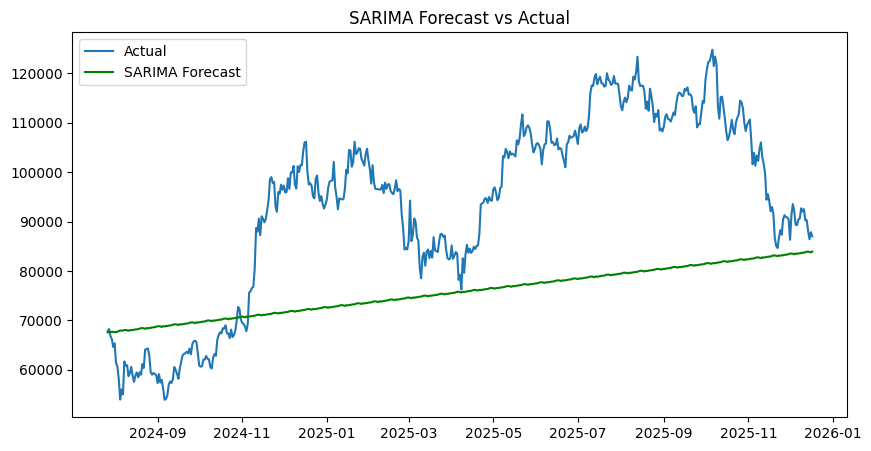

In [20]:
plt.figure(figsize=(10,5))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green')
plt.legend()
plt.title('SARIMA Forecast vs Actual')
plt.show()


In [21]:
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))
print("SARIMA RMSE:", sarima_rmse)


SARIMA RMSE: 23438.204858040477


In [22]:
!pip install prophet


In [23]:
from prophet import Prophet

prophet_df = df.reset_index()[['Date', 'Close']]
prophet_df.columns = ['ds', 'y']


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


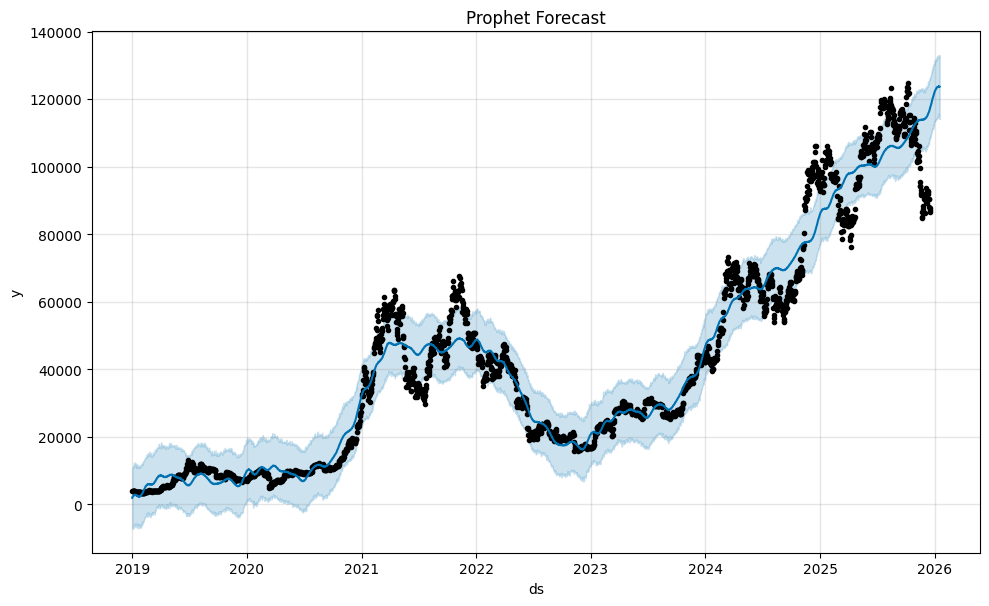

In [24]:
prophet_model = Prophet()
prophet_model.fit(prophet_df)

future = prophet_model.make_future_dataframe(periods=30)
prophet_forecast = prophet_model.predict(future)

prophet_model.plot(prophet_forecast)
plt.title('Prophet Forecast')
plt.show()


In [25]:
!pip install tensorflow


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [27]:
data = df[['Close']].values


In [28]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)


In [29]:
X = []
y = []

for i in range(60, len(scaled_data)):
    X.append(scaled_data[i-60:i, 0])
    y.append(scaled_data[i, 0])

X, y = np.array(X), np.array(y)


In [30]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))


In [31]:
model = Sequential()
model.add(LSTM(50, return_sequences=False, input_shape=(X_train.shape[1], 1)))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [32]:
model.fit(X_train, y_train, epochs=5, batch_size=32)


Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0205
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.7950e-04
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 4.3002e-04
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - loss: 3.8152e-04
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.6392e-04


In [33]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)

y_test_actual = scaler.inverse_transform(y_test.reshape(-1,1))


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


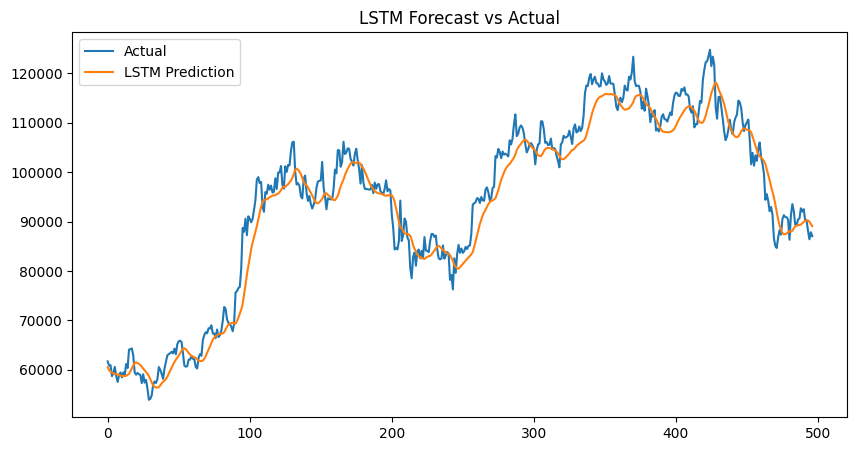

In [34]:
plt.figure(figsize=(10,5))
plt.plot(y_test_actual, label='Actual')
plt.plot(predictions, label='LSTM Prediction')
plt.title('LSTM Forecast vs Actual')
plt.legend()
plt.show()


In [35]:
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
print("LSTM RMSE:", lstm_rmse)


LSTM RMSE: 4029.1502593362006
